### 1. Upload Libraries

In [28]:
import seaborn as sns
from pathlib import Path
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.exceptions import ConvergenceWarning
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from shapely.geometry import LineString, Point
import networkx as nx
from sklearn.cluster import AgglomerativeClustering
 

root_path = Path().resolve()
daten_path = root_path / "input"
output_path = root_path / "output"


target_crs = "EPSG:32632"

### 2. Upload Project Area

In [29]:
gdf_area = gpd.read_file(daten_path / "gdf_area.geojson")
area_poly = gdf_area.geometry.union_all()

### 3. Upload Abwärme

In [30]:
csv_path = daten_path / "df_abwaerme_hyBit.csv"
df_ab = pd.read_csv(csv_path, sep=";", encoding="utf-8")

### 4. Upload Heat

In [31]:
csv_path = daten_path / "df_lp_heat_hybit.csv"
stunden_cols = [f"Stunde {i}" for i in range(1, 8761)]
columns_to_read = ["ID", "NACE", "Nettobedarfsflaeche"] + stunden_cols
df_ht = pd.read_csv(csv_path, usecols= columns_to_read, sep=";", encoding="utf-8")
df_ht['heat_gesamt'] = df_ht[stunden_cols].sum(axis=1)
insert_pos = df_ht.columns.get_loc("Stunde 1")
cols = df_ht.columns.tolist()
cols.remove("heat_gesamt")
cols.insert(insert_pos, "heat_gesamt")
df_ht = df_ht[cols]


### 5. Stored heat and heat waste load profiles in time indexed df

In [32]:
# Define the hourly index for the latest available year
year = 2024
time_index = pd.date_range(start=f'{year}-01-01 00:00', periods=8760, freq='h')

# Extract and structure load profiles from sources
source_profile_cols = [f'Stunde {i}' for i in range(1, 8761)]
df_source_loads = df_ab.set_index('ID')[source_profile_cols].transpose()
df_source_loads.index = time_index
df_source_loads.columns.name = 'Source_ID'

# Extract and structure load profiles from consumers
consumer_profile_cols = [f'Stunde {i}' for i in range(1, 8761)]
df_consumer_loads = df_ht.set_index('ID')[consumer_profile_cols].transpose()
df_consumer_loads.index = time_index
df_consumer_loads.columns.name = 'Consumer_ID'

### 5. Upload GIS DATA

In [33]:
import os
import geopandas as gpd

os.environ["OGR_GEOMETRY_ACCEPT_UNCLOSED_RING"] = "YES"
gis_path = daten_path / "df_LP_geschossanzahl_hyBit.geojson"
gdf_gis = gpd.read_file(gis_path)
gdf_gis = gdf_gis.to_crs(epsg=32632)

/home/zaba_al/mambaforge/envs/flexigis/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: Non closed ring detected.
  return ogr_read(


### 6. Build Road Network

In [34]:
gdf_road = gpd.read_file(daten_path / "roads.geojson").to_crs(target_crs)
gdf_road = gdf_road[gdf_road.geometry.intersects(area_poly)].copy()
gdf_road = gdf_road.to_crs(target_crs)
gdf_road = gdf_road[~gdf_road.geometry.is_empty].copy()
gdf_road = gdf_road[gdf_road.geometry.type.isin(["LineString", "MultiLineString"])].copy()

### Lenght of the road

In [35]:
# Ensure your CRS is in meters (EPSG:32632 = meters)
assert gdf_road.crs.to_epsg() == 32632

# Calculate total length in meters
total_length_m = gdf_road.length.sum()

# Convert to kilometers
total_length_km = total_length_m / 1000

print(f"Total road length: {total_length_km:.2f} km")

Total road length: 606.86 km


### 7. Find the n biggest heat sources

In [36]:
top_n = 20 # Biggest Abwärme sources 
topn_abwaerme = df_ab.sort_values("Abwaerme_gesamt", ascending=False).head(top_n)
top_ids = topn_abwaerme["ID"].tolist()


/tmp/ipykernel_5008/3951091272.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


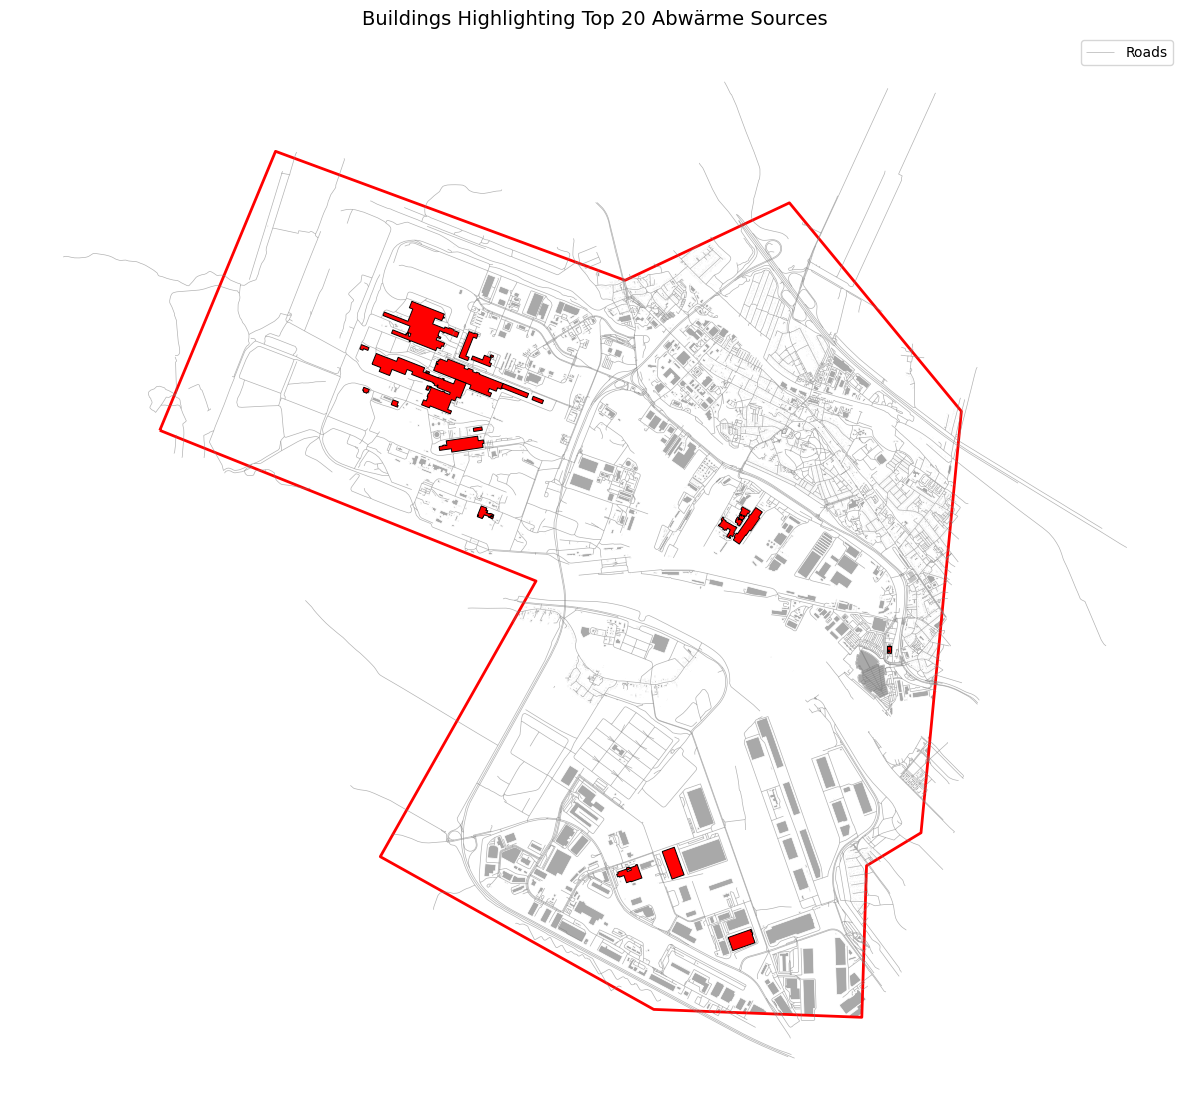

In [37]:
# Separate the highlighted buildings
highlighted = gdf_gis[gdf_gis["ID"].isin(top_ids)]
others = gdf_gis[~gdf_gis["ID"].isin(top_ids)]

# Plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot roads first (background)
gdf_road.plot(ax=ax, color="gray", linewidth=0.5, alpha=0.6, label="Roads")

# Plot all other buildings
others.plot(ax=ax, color="darkgray", linewidth=0.5, edgecolor="white")

# Highlight selected buildings
highlighted.plot(ax=ax, color="red", edgecolor="black", linewidth=0.7, label="Top Abwärme")

# Plot boundary area polygon
gpd.GeoSeries([area_poly]).plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2, label="Area Boundary")

# Final formatting
ax.set_title(f"Buildings Highlighting Top {top_n} Abwärme Sources", fontsize=14)
ax.axis("off")
ax.legend()
plt.tight_layout()
plt.show()

### 8. Compute the distances between the top Abwärme buildings

### 8.1 Find centroids of Abärme sources

In [38]:
# Get geometries from gdf_gis
gdf_top = gdf_gis[gdf_gis["ID"].isin(top_ids)].copy()
gdf_top["centroid"] = gdf_top.geometry.centroid  # use centroids for distance


### 8.2 Compute Pairwise Distances

In [39]:
from shapely.geometry import Point
import pandas as pd

# Create distance matrix
distance_matrix = pd.DataFrame(index=gdf_top["ID"], columns=gdf_top["ID"], dtype=float)

for i, row_i in gdf_top.iterrows():
    for j, row_j in gdf_top.iterrows():
        dist = row_i["centroid"].distance(row_j["centroid"])
        distance_matrix.at[row_i["ID"], row_j["ID"]] = dist


### 9. Form clusters based on their separation

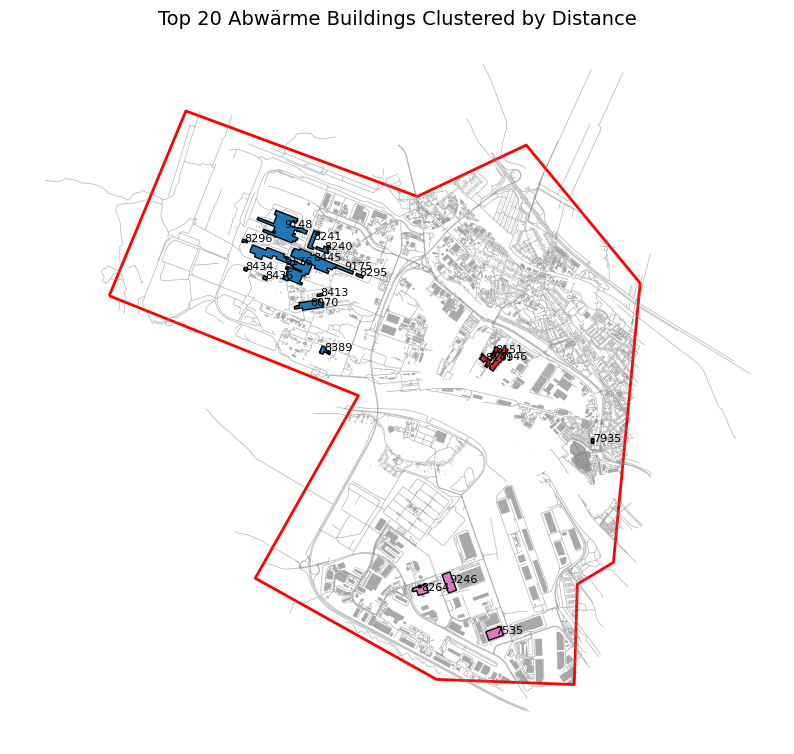

In [40]:
# Convert distance matrix to NumPy array (and fill diagonal with 0 just in case)
distance_array = distance_matrix.fillna(0).values.astype(float)
np.fill_diagonal(distance_array, 0)

# Choose number of clusters
n_clusters = 4  # you can adjust this
clustering = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='precomputed',
    linkage='average'
)


labels = clustering.fit_predict(distance_array)

gdf_top["cluster"] = labels
gpd.GeoSeries([area_poly]).plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2, label="Area Boundary")


fig, ax = plt.subplots(figsize=(10, 10))
# Plot roads first (so buildings are visible on top)
gdf_road.plot(ax=ax, color="gray", linewidth=0.5, alpha=0.6, label="Roads")
gdf_gis.plot(ax=ax, color="darkgray")  # background
gdf_top.plot(ax=ax, column="cluster", cmap="tab10", legend=False, edgecolor="black")

for i, row in gdf_top.iterrows():
    ax.annotate(str(row["ID"]), xy=row["centroid"].coords[0], fontsize=8, color="black")
ax.set_title(f"Top {top_n} Abwärme Buildings Clustered by Distance", fontsize=14)
gpd.GeoSeries([area_poly]).plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2, label="Area Boundary")
ax.axis("off")
plt.show()

fig.savefig(output_path / "clustered_abwaerme_buildings.png", dpi=300)


### 9. Aggregate the Abwärme load profiles by cluster

In [41]:
# Ensure we have the mapping from source ID to cluster
source_clusters = gdf_top.set_index("ID")["cluster"].to_dict()
# Assign each source column to its cluster
clustered_columns = {}
for col in df_source_loads.columns:
    cluster = source_clusters.get(col)
    if cluster is not None:
        clustered_columns.setdefault(cluster, []).append(col)

# Create a DataFrame to hold aggregated cluster profiles
df_cluster_profiles = pd.DataFrame(index=df_source_loads.index)

# Sum load profiles for each cluster
for cluster, cols in clustered_columns.items():
    df_cluster_profiles[f"Cluster {cluster}"] = df_source_loads[cols].sum(axis=1)


### 9.1 Plot aggreagted Abwärme load profiles

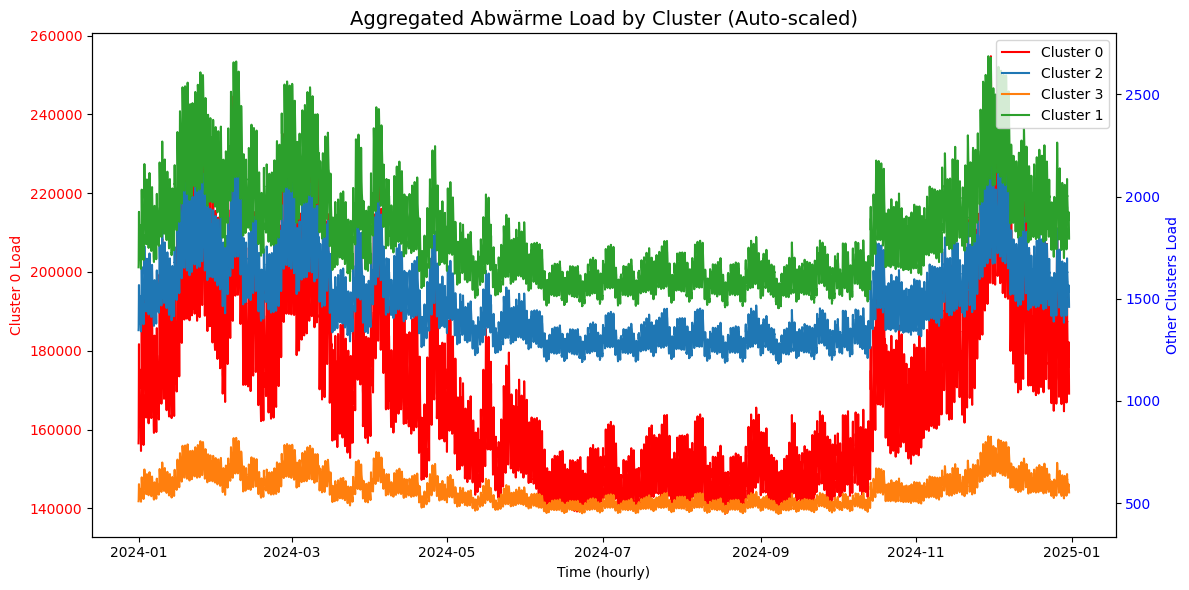

In [42]:
# Step 1: Calculate total energy per cluster (sum over all hours)
totals = df_cluster_profiles.sum()

# Step 2: Compute ratio of max to second-largest cluster
sorted_totals = totals.sort_values(ascending=False)
max_total = sorted_totals.iloc[0]
second_max = sorted_totals.iloc[1] if len(sorted_totals) > 1 else max_total
ratio = max_total / second_max

# Step 3: Decide whether to use dual axes
use_dual_axes = ratio > 5  # Threshold can be adjusted

# Step 4: Plot accordingly
fig, ax1 = plt.subplots(figsize=(12, 6))

if use_dual_axes:
    # Split off the dominant cluster
    dominant_cluster = sorted_totals.index[0]
    other_clusters = df_cluster_profiles.drop(columns=[dominant_cluster])

    # Left axis: dominant
    ax1.plot(df_cluster_profiles.index, df_cluster_profiles[dominant_cluster], color='red', label=dominant_cluster)
    ax1.set_ylabel(f"{dominant_cluster} Load", color='red')
    ax1.tick_params(axis='y', labelcolor='red')

    # Right axis: other clusters
    ax2 = ax1.twinx()
    for col in other_clusters.columns:
        ax2.plot(df_cluster_profiles.index, other_clusters[col], label=col)
    ax2.set_ylabel("Other Clusters Load", color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Combine legends
    lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    ax2.legend(lines, labels, loc='upper right')
else:
    # Single axis for all
    for col in df_cluster_profiles.columns:
        ax1.plot(df_cluster_profiles.index, df_cluster_profiles[col], label=col)
    ax1.set_ylabel("Cluster Load")
    ax1.legend()

ax1.set_title("Aggregated Abwärme Load by Cluster (Auto-scaled)", fontsize=14)
ax1.set_xlabel("Time (hourly)")
plt.tight_layout()
plt.show()




### 10 . Example of identification of heat demand of surrounding nearest buildings for biggest cluster -> Cluster 0

### 10.1 Identify buldings 

In [43]:
# Get the IDs in Cluster 0
cluster0_ids = gdf_top[gdf_top["cluster"] == 0]["ID"]

# Filter geometries for those IDs
cluster0_buildings = gdf_gis[gdf_gis["ID"].isin(cluster0_ids)]

# Use the unary_union of all geometries and get its centroid
cluster0_centroid = cluster0_buildings.geometry.union_all().centroid

### 10.2 Select buildings in a buffer of n km

In [44]:
# 0. Ensure consistent ID types
gdf_gis["ID"] = gdf_gis["ID"].astype(str)
gdf_top["ID"] = gdf_top["ID"].astype(str)

# 1. Get IDs of buildings in Cluster 0
cluster0_ids = gdf_top[gdf_top["cluster"] == 0]["ID"].tolist()

bf = 3000 # meters of buffering

# 2. Create 100-meter buffer around cluster centroid
buffer = cluster0_centroid.buffer(bf)

# 3. Filter gdf_gis: intersecting buffer AND NOT in Cluster 0
nearby_buildings = gdf_gis[
    gdf_gis["geometry"].intersects(buffer) & ~gdf_gis["ID"].isin(cluster0_ids)
]

# # 4. Extract clean list of IDs
# nearby_ids = nearby_buildings["ID"].tolist()

# print("Nearby building IDs within 100m of Cluster 0 centroid (excluding cluster members):", nearby_ids)




### 10.3 Plot sinks and sources in a radius of  n meters

/tmp/ipykernel_5008/429061748.py:57: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


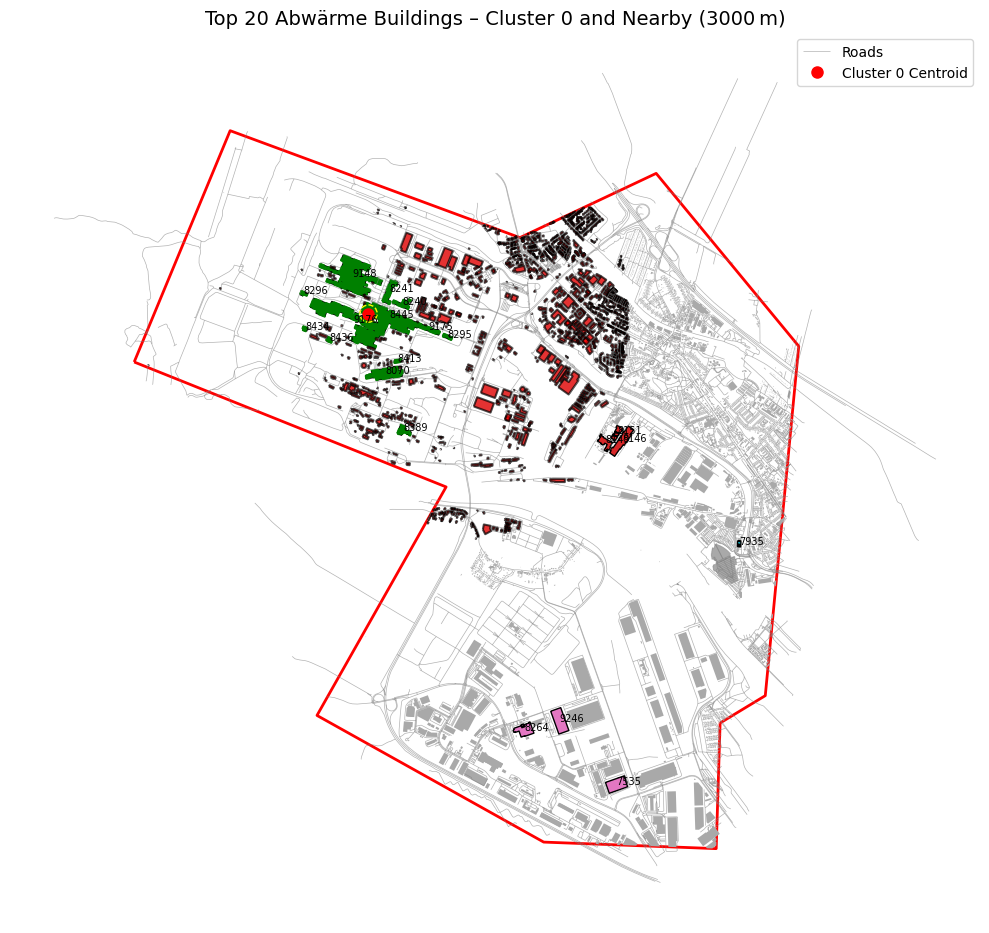

In [45]:
# 1. Get buildings in Cluster 0
cluster0_ids = gdf_top[gdf_top["cluster"] == 0]["ID"]
cluster0_buildings = gdf_gis[gdf_gis["ID"].isin(cluster0_ids)]

# 2. Compute centroid of Cluster 0
cluster0_centroid = cluster0_buildings.union_all().centroid

# 3. Get geometries of nearby buildings not part of the cluster
# Recompute buffer (this was missing)
# Recompute the 100-meter buffer from the current centroid
#buffer = cluster0_centroid.buffer(100)

# Get updated nearby buildings (excluding cluster 0)
nearby_buildings = gdf_gis[
    gdf_gis["geometry"].intersects(buffer) & ~gdf_gis["ID"].isin(cluster0_ids)
]

# 4. Plot everything
fig, ax = plt.subplots(figsize=(10, 10))

# Plot roads first (so buildings are visible on top)
gdf_road.plot(ax=ax, color="gray", linewidth=0.5, alpha=0.6, label="Roads")

# Plot boundary area polygon
gpd.GeoSeries([area_poly]).plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2, linestyle='-', label="Area Boundary")

# Background: all buildings
gdf_gis.plot(ax=ax, color="darkgray", linewidth=0.2)

# All clustered top buildings (color by cluster)
gdf_top.plot(ax=ax, column="cluster", cmap="tab10", legend=False, edgecolor="black")

# Cluster 0 buildings in blue outline
cluster0_buildings.plot(ax=ax, facecolor="green", edgecolor="green", linewidth=1.5, linestyle='--', label="Cluster 0")

# Nearby buildings within 100 m in green
nearby_buildings.plot(ax=ax, facecolor="red", edgecolor="black", linewidth=1.5, alpha=0.7, label="Within 100m of Cluster 0")

# Plot centroid as a red point
ax.plot(cluster0_centroid.x, cluster0_centroid.y, 'ro', markersize=8, label="Cluster 0 Centroid")

# Optional: draw 100m radius circle
circle = plt.Circle((cluster0_centroid.x, cluster0_centroid.y), 100, color='yellow', fill=False, linestyle='--')
ax.add_patch(circle)

# Annotate top buildings by ID
for i, row in gdf_top.iterrows():
    ax.annotate(str(row["ID"]), xy=row["centroid"].coords[0], fontsize=7, color="black")

# for i, row in nearby_buildings.iterrows():
#     centroid = row["geometry"].centroid
#     ax.annotate(str(row["ID"]), xy=centroid.coords[0], fontsize=6, color="blue")


ax.set_title(f"Top {top_n} Abwärme Buildings – Cluster 0 and Nearby ({bf} m)", fontsize=14)
ax.axis("off")
ax.legend()
plt.tight_layout()
plt.show()

### 10.4 Estimate total_cluster_abwaerme_MWh and Wärmebedarf from nearby buildings

In [46]:
cluster0_abwaerme = df_cluster_profiles["Cluster 0"]  # hourly profile
total_cluster0_abwaerme_MWh = cluster0_abwaerme.sum() / 1000  # assuming values are in kWh

# 1. Get list of nearby building IDs (still strings if from GeoDataFrame)
nearby_ids = nearby_buildings["ID"].tolist()
# 2. Convert to int to match df_consumer_loads.columns (if needed)
nearby_ids = [int(i) for i in nearby_ids]
# 3. Extract hourly profiles
df_nearby_demand = df_consumer_loads[nearby_ids].copy()
# 4. Sum all demand across those buildings (per hour)
total_demand_profile = df_nearby_demand.sum(axis=1)
# 5. Calculate total annual demand in MWh
total_nearby_demand_MWh = total_demand_profile.sum() / 1000


### 10.5 Plot use of heat waste from surrounding buildings

✅ 100% of the heat demand is covered by Cluster 0 Abwärme.
➕ There is 1208769.7 MWh (432.4%) surplus available to cover more buildings.


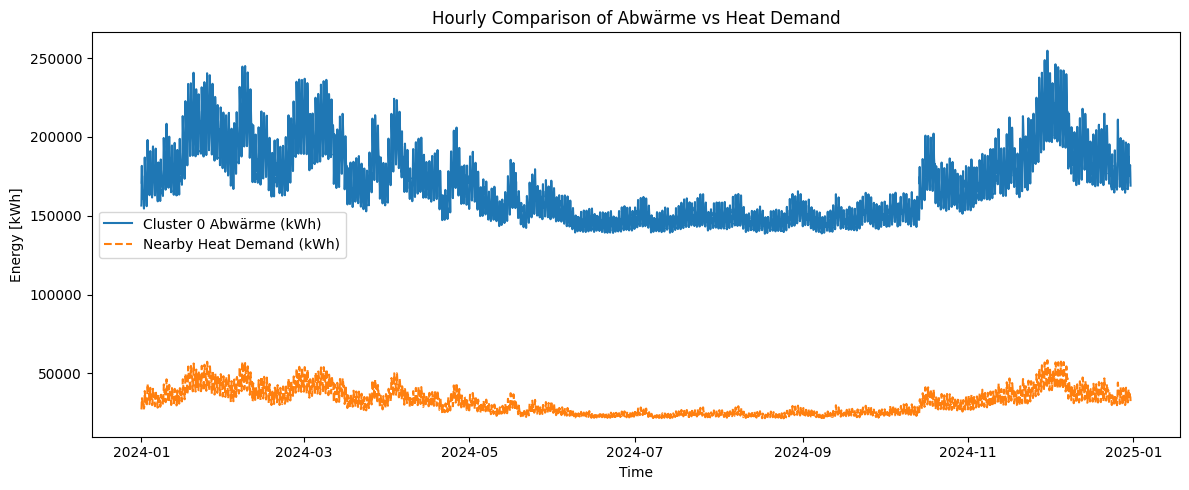

In [47]:
import matplotlib.pyplot as plt

if total_cluster0_abwaerme_MWh >= total_nearby_demand_MWh:
    surplus = total_cluster0_abwaerme_MWh - total_nearby_demand_MWh
    surplus_pct = (surplus / total_nearby_demand_MWh) * 100
    print(f"✅ 100% of the heat demand is covered by Cluster 0 Abwärme.")
    print(f"➕ There is {surplus:.1f} MWh ({surplus_pct:.1f}%) surplus available to cover more buildings.")
else:
    coverage_pct = (total_cluster0_abwaerme_MWh / total_nearby_demand_MWh) * 100
    print(f"⚠️ Only {coverage_pct:.1f}% of the nearby heat demand can be covered by Cluster 0 Abwärme.")
    print(f"Deficit: {total_nearby_demand_MWh - total_cluster0_abwaerme_MWh:.1f} MWh")



fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(cluster0_abwaerme.index, cluster0_abwaerme, label="Cluster 0 Abwärme (kWh)")
ax.plot(total_demand_profile.index, total_demand_profile, label="Nearby Heat Demand (kWh)", linestyle='--')
ax.set_title("Hourly Comparison of Abwärme vs Heat Demand")
ax.set_ylabel("Energy [kWh]")
ax.set_xlabel("Time")
ax.legend()
plt.tight_layout()
plt.show()




### 10.6 Check coverage in a maximum radio range of 6 km

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import ace_tools_open as tools

# Preprocessing
cluster0_ids = gdf_top[gdf_top["cluster"] == 0]["ID"].astype(str).tolist()
cluster0_buildings = gdf_gis[gdf_gis["ID"].astype(str).isin(cluster0_ids)]
cluster0_centroid = cluster0_buildings.geometry.union_all().centroid

cluster0_abwaerme = df_cluster_profiles["Cluster 0"]
total_cluster0_abwaerme_MWh = cluster0_abwaerme.sum() / 1000  # kWh → MWh

# Loop settings
max_radius = 6000
step = 100
threshold = 0.90
best_radius = None
last_success_radius = None
final_nearby_buildings = None
result_log = []

# Iterative expansion loop
for radius in range(step, max_radius + step, step):
    buffer = cluster0_centroid.buffer(radius)

    nearby_buildings = gdf_gis[
        gdf_gis["geometry"].intersects(buffer) & ~gdf_gis["ID"].astype(str).isin(cluster0_ids)
    ]

    nearby_ids = nearby_buildings["ID"].astype(int).tolist()
    nearby_ids = [i for i in nearby_ids if i in df_consumer_loads.columns]

    if not nearby_ids:
        continue

    df_nearby_demand = df_consumer_loads[nearby_ids].copy()
    total_demand_profile = df_nearby_demand.sum(axis=1)
    total_nearby_demand_MWh = total_demand_profile.sum() / 1000

    if total_nearby_demand_MWh == 0:
        continue

    coverage_ratio = total_cluster0_abwaerme_MWh / total_nearby_demand_MWh

    result_log.append({
        "buffer_m": radius,
        "demand_MWh": total_nearby_demand_MWh,
        "coverage_%": min(coverage_ratio, 1.0) * 100,
        "surplus_MWh": max(total_cluster0_abwaerme_MWh - total_nearby_demand_MWh, 0)
    })

    last_success_radius = radius
    final_nearby_buildings = nearby_buildings.copy()

    if coverage_ratio < threshold:
        best_radius = radius
        break

# If threshold never crossed, fall back to last iteration
if best_radius is None:
    best_radius = last_success_radius
    print(f"✅ Coverage never dropped below 90%; using final radius {best_radius}m")

# Show summary
tools.display_dataframe_to_user(name="Buffer Coverage Summary", dataframe=pd.DataFrame(result_log))


✅ Coverage never dropped below 90%; using final radius 6000m
Buffer Coverage Summary


/tmp/ipykernel_5008/3498773351.py:52: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


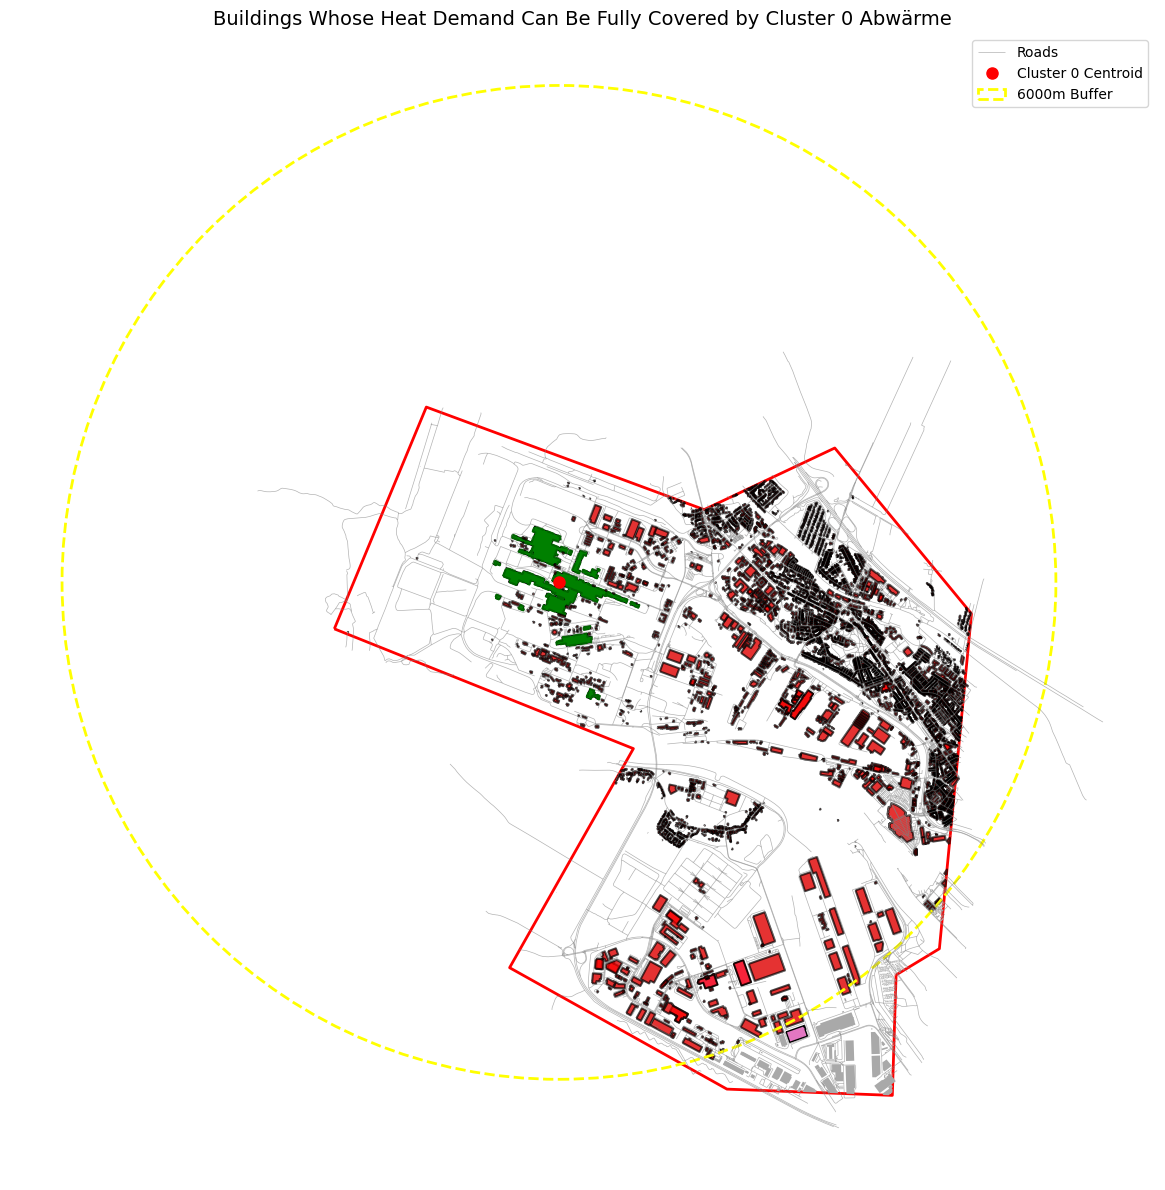

In [49]:
# 1. Extract hourly load profiles for final nearby buildings
nearby_ids_all = final_nearby_buildings["ID"].astype(int).tolist()
nearby_ids_all = [i for i in nearby_ids_all if i in df_consumer_loads.columns]
df_final_nearby_profiles = df_consumer_loads[nearby_ids_all]

# Step 2: Compute total annual demand per building (MWh)
building_total_MWh = df_final_nearby_profiles.sum() / 1000  # kWh to MWh
building_total_MWh = building_total_MWh.sort_values()  # ascending order

# Step 3: Select only those buildings whose cumulative demand fits within available Abwärme
covered_ids = []
cumulative = 0
for bid, demand in building_total_MWh.items():
    if cumulative + demand <= total_cluster0_abwaerme_MWh:
        covered_ids.append(bid)
        cumulative += demand
    else:
        break

# Step 4: Map to GeoDataFrame
covered_buildings = gdf_gis[gdf_gis["ID"].astype(int).isin(covered_ids)]

# Step 5: Plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot roads first
gdf_road.plot(ax=ax, color="gray", linewidth=0.5, alpha=0.6, label="Roads")

# Plot area boundary polygon
gpd.GeoSeries([area_poly]).plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2, linestyle='-', label="Area Boundary")

# Background buildings
gdf_gis.plot(ax=ax, color="darkgray", linewidth=0.2)

# Top buildings by cluster
gdf_top.plot(ax=ax, column="cluster", cmap="tab10", legend=False, edgecolor="black")

# Cluster 0 buildings
cluster0_buildings.plot(ax=ax, facecolor="green", edgecolor="darkgreen", linewidth=1.5, linestyle='--', label="Cluster 0")

# Buildings whose demand is covered
covered_buildings.plot(ax=ax, facecolor="red", edgecolor="black", linewidth=1.5, alpha=0.7, label="Covered Demand")

# Centroid & buffer
ax.plot(cluster0_centroid.x, cluster0_centroid.y, 'ro', markersize=8, label="Cluster 0 Centroid")
circle = plt.Circle((cluster0_centroid.x, cluster0_centroid.y), best_radius, color='yellow', fill=False, linestyle='--', linewidth=2, label=f"{best_radius}m Buffer")
ax.add_patch(circle)

# Title and legend
ax.set_title("Buildings Whose Heat Demand Can Be Fully Covered by Cluster 0 Abwärme", fontsize=14)
ax.axis("off")
ax.legend()
plt.tight_layout()
plt.show()



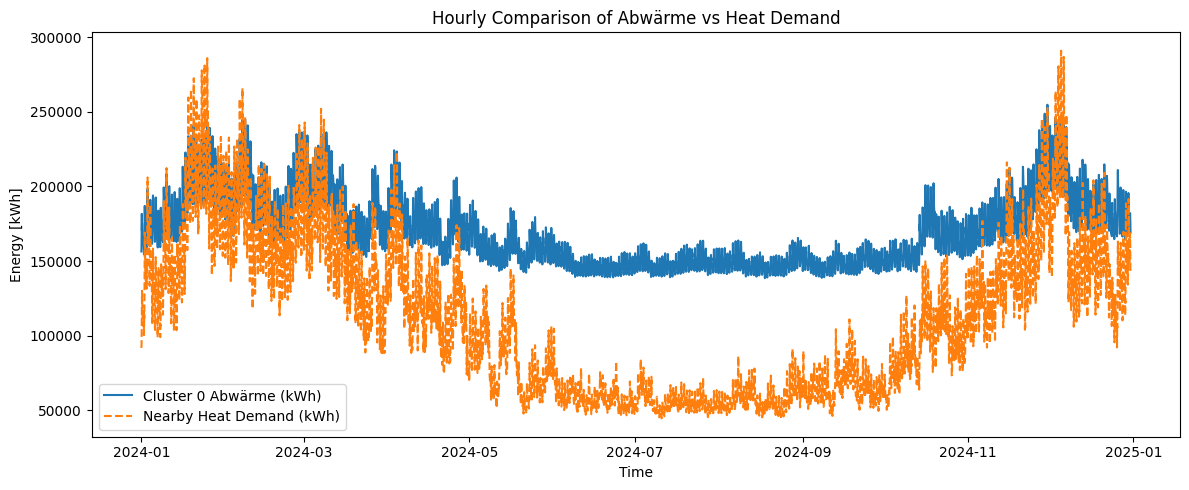

In [50]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(cluster0_abwaerme.index, cluster0_abwaerme, label="Cluster 0 Abwärme (kWh)")
ax.plot(total_demand_profile.index, total_demand_profile, label="Nearby Heat Demand (kWh)", linestyle='--')
ax.set_title("Hourly Comparison of Abwärme vs Heat Demand")
ax.set_ylabel("Energy [kWh]")
ax.set_xlabel("Time")
ax.legend()
plt.tight_layout()
plt.show()


### Examplary use in other clusters

🔍 Processing Cluster 0
Cluster 0: Coverage never dropped below 90%; using 2000m


/tmp/ipykernel_5008/96875220.py:107: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


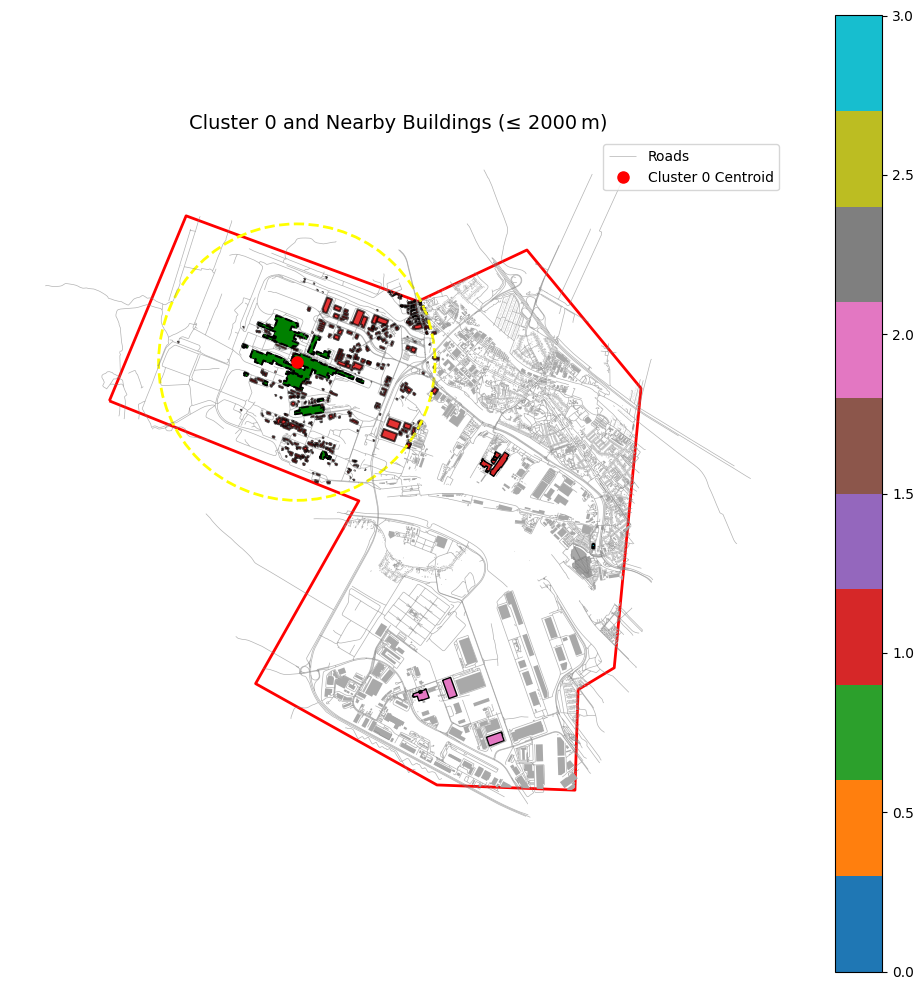

🔍 Processing Cluster 1
Cluster 1: Coverage dropped below 90% at 500m


/tmp/ipykernel_5008/96875220.py:107: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


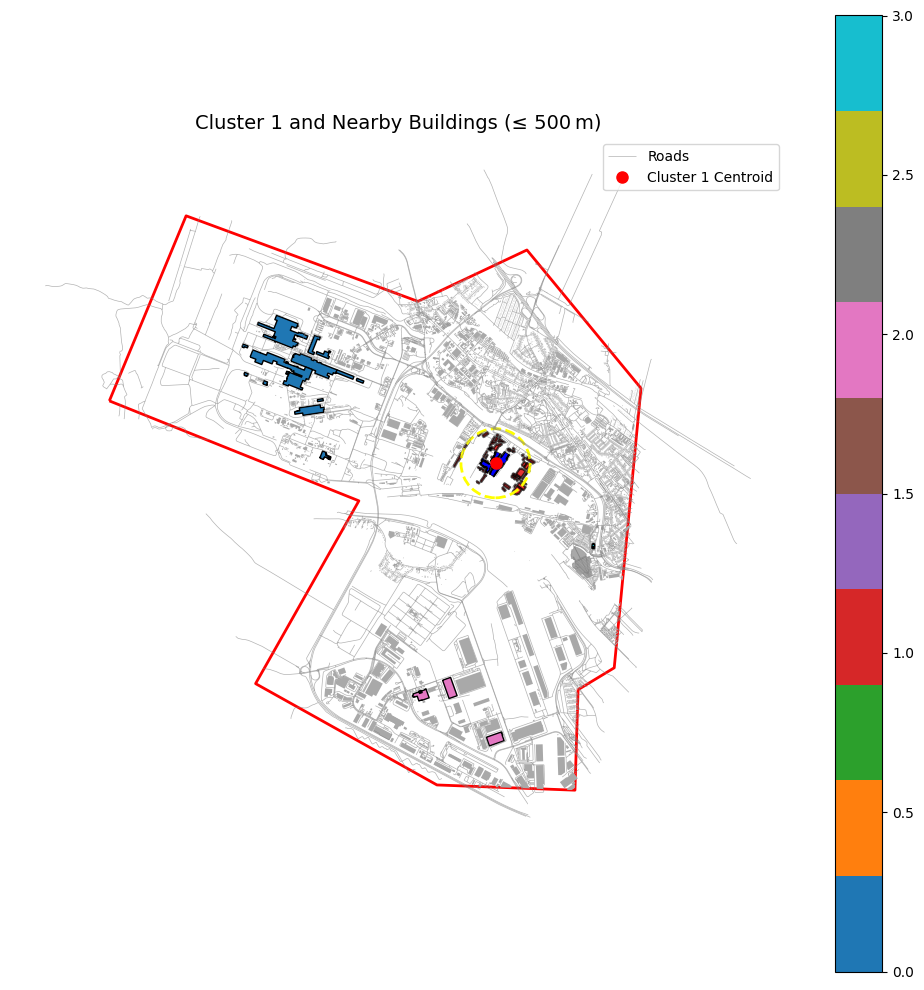

🔍 Processing Cluster 2
Cluster 2: Coverage dropped below 90% at 300m


/tmp/ipykernel_5008/96875220.py:107: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


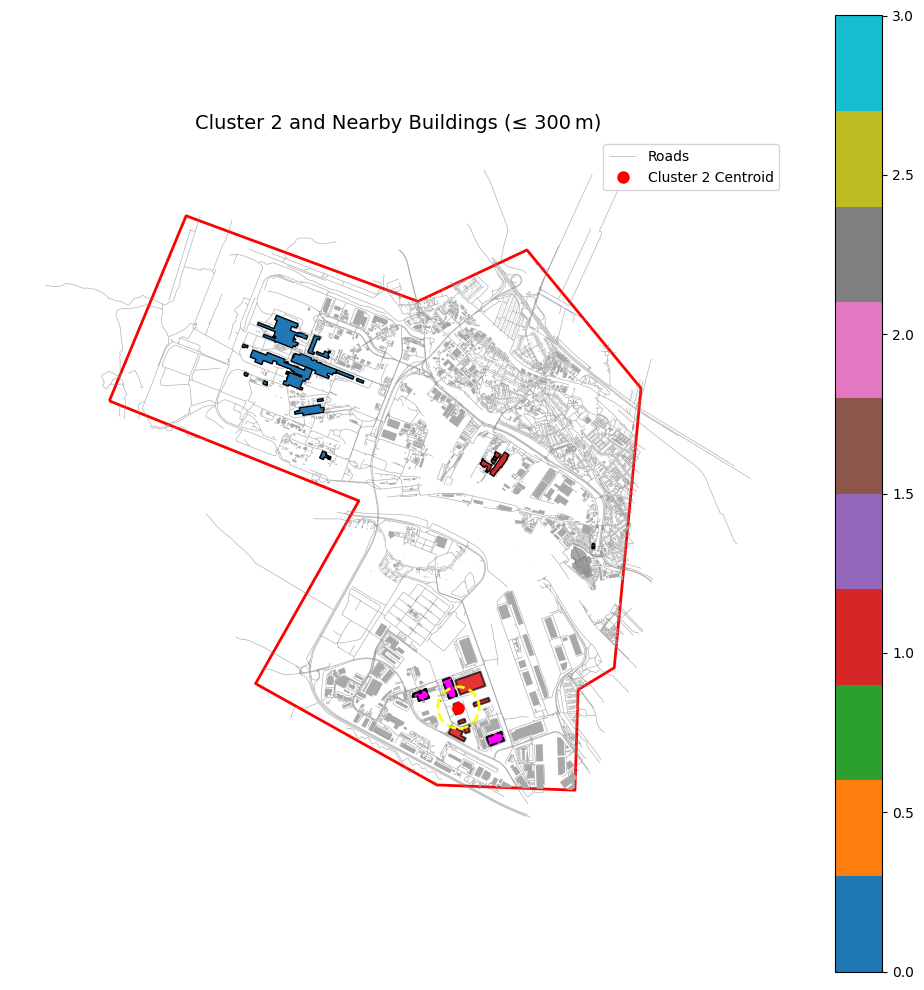

🔍 Processing Cluster 3
Cluster 3: Coverage dropped below 90% at 200m


/tmp/ipykernel_5008/96875220.py:107: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


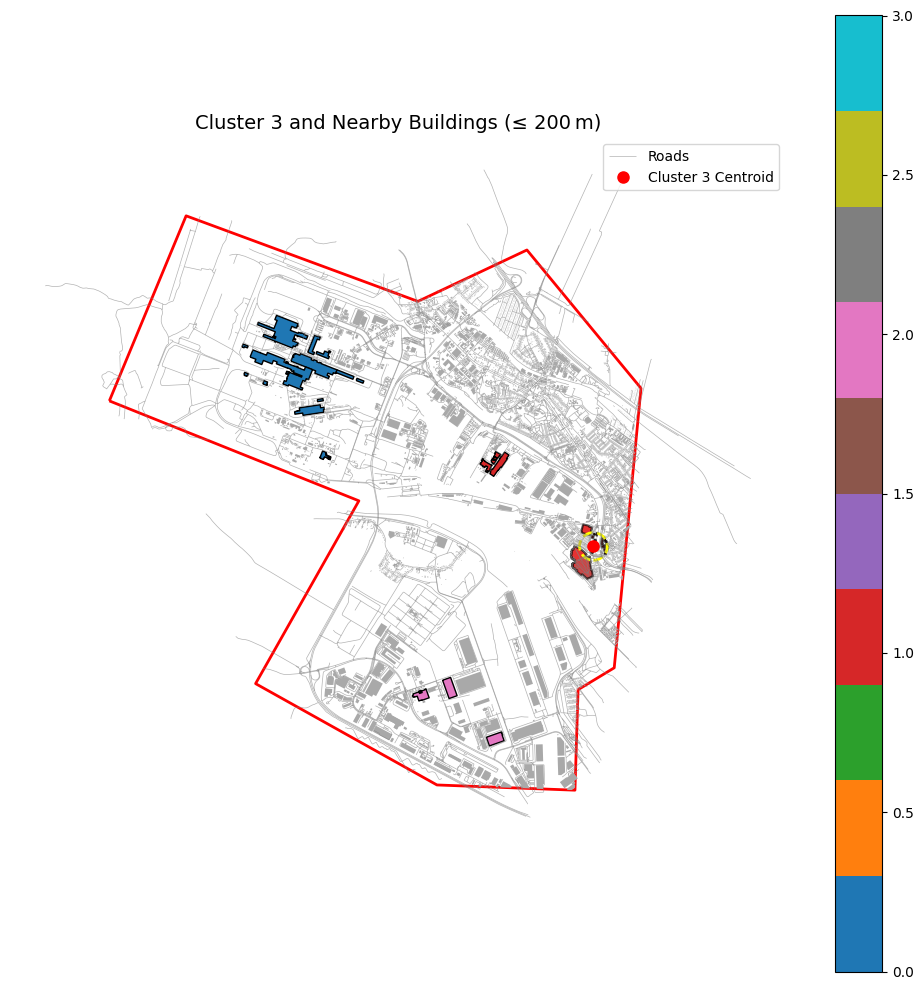

All Cluster Buffer Coverage Summary


In [51]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import to_rgba

# Cluster colors for up to 4 clusters
cluster_colors = {
    0: "green",
    1: "blue",
    2: "magenta",
    3: "pink"
}

summary_records = []

# Iterate over each cluster (0 to 3)
for cluster_id in range(4):
    cluster_name = f"Cluster {cluster_id}"
    print(f"🔍 Processing {cluster_name}")

    # Get buildings in the current cluster
    cluster_ids = gdf_top[gdf_top["cluster"] == cluster_id]["ID"].astype(str).tolist()
    cluster_buildings = gdf_gis[gdf_gis["ID"].astype(str).isin(cluster_ids)]
    cluster_centroid = cluster_buildings.geometry.union_all().centroid

    abwaerme_profile = df_cluster_profiles[cluster_name]
    total_abwaerme_MWh = abwaerme_profile.sum() / 1000  # kWh → MWh

    max_radius = 2000
    step = 100
    threshold = 0.90
    best_radius = None
    last_success_radius = None
    final_nearby_buildings = None
    result_log = []

    for radius in range(step, max_radius + step, step):
        buffer = cluster_centroid.buffer(radius)

        nearby_buildings = gdf_gis[
            gdf_gis["geometry"].intersects(buffer) & ~gdf_gis["ID"].astype(str).isin(cluster_ids)
        ]

        nearby_ids = nearby_buildings["ID"].astype(int).tolist()
        nearby_ids = [i for i in nearby_ids if i in df_consumer_loads.columns]

        if not nearby_ids:
            continue

        df_nearby_demand = df_consumer_loads[nearby_ids].copy()
        total_demand_profile = df_nearby_demand.sum(axis=1)
        total_nearby_demand_MWh = total_demand_profile.sum() / 1000

        if total_nearby_demand_MWh == 0:
            continue

        coverage_ratio = total_abwaerme_MWh / total_nearby_demand_MWh

        result_log.append({
            "cluster": cluster_name,
            "buffer_m": radius,
            "demand_MWh": total_nearby_demand_MWh,
            "coverage_%": min(coverage_ratio, 1.0) * 100,
            "surplus_MWh": max(total_abwaerme_MWh - total_nearby_demand_MWh, 0)
        })

        last_success_radius = radius
        final_nearby_buildings = nearby_buildings.copy()

        if coverage_ratio < threshold:
            best_radius = radius
            break

    if best_radius is None:
        best_radius = last_success_radius
        print(f"{cluster_name}: Coverage never dropped below 90%; using {best_radius}m")
    else:
        print(f"{cluster_name}: Coverage dropped below 90% at {best_radius}m")

    # Add to summary
    summary_records.extend(result_log)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot roads
    gdf_road.plot(ax=ax, color="gray", linewidth=0.5, alpha=0.6, label="Roads")

    # ✅ Plot area_poly boundary
    gpd.GeoSeries([area_poly]).plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2, linestyle='-', label="Area Boundary")

    # Plot all buildings
    gdf_gis.plot(ax=ax, color="darkgray", linewidth=0.2)
    gdf_top.plot(ax=ax, column="cluster", cmap="tab10", legend=True, edgecolor="black")

    # Cluster-specific and demand-covered buildings
    cluster_buildings.plot(ax=ax, facecolor=cluster_colors[cluster_id], edgecolor="black", linewidth=1.5, linestyle='--', label=f"{cluster_name} Buildings")
    final_nearby_buildings.plot(ax=ax, facecolor="red", edgecolor="black", linewidth=1.5, alpha=0.7, label=f"Nearby Demand ≤ {best_radius}m")


    # Plot centroid and buffer
    ax.plot(cluster_centroid.x, cluster_centroid.y, 'ro', markersize=8, label=f"{cluster_name} Centroid")
    circle = plt.Circle((cluster_centroid.x, cluster_centroid.y), best_radius, color='yellow', fill=False, linestyle='--', linewidth=2)
    ax.add_patch(circle)

    ax.set_title(f"{cluster_name} and Nearby Buildings (≤ {best_radius} m)", fontsize=14)
    ax.axis("off")
    ax.legend()
    plt.tight_layout()
    plt.show()

# Display buffer summary table
tools.display_dataframe_to_user(name="All Cluster Buffer Coverage Summary", dataframe=pd.DataFrame(summary_records))


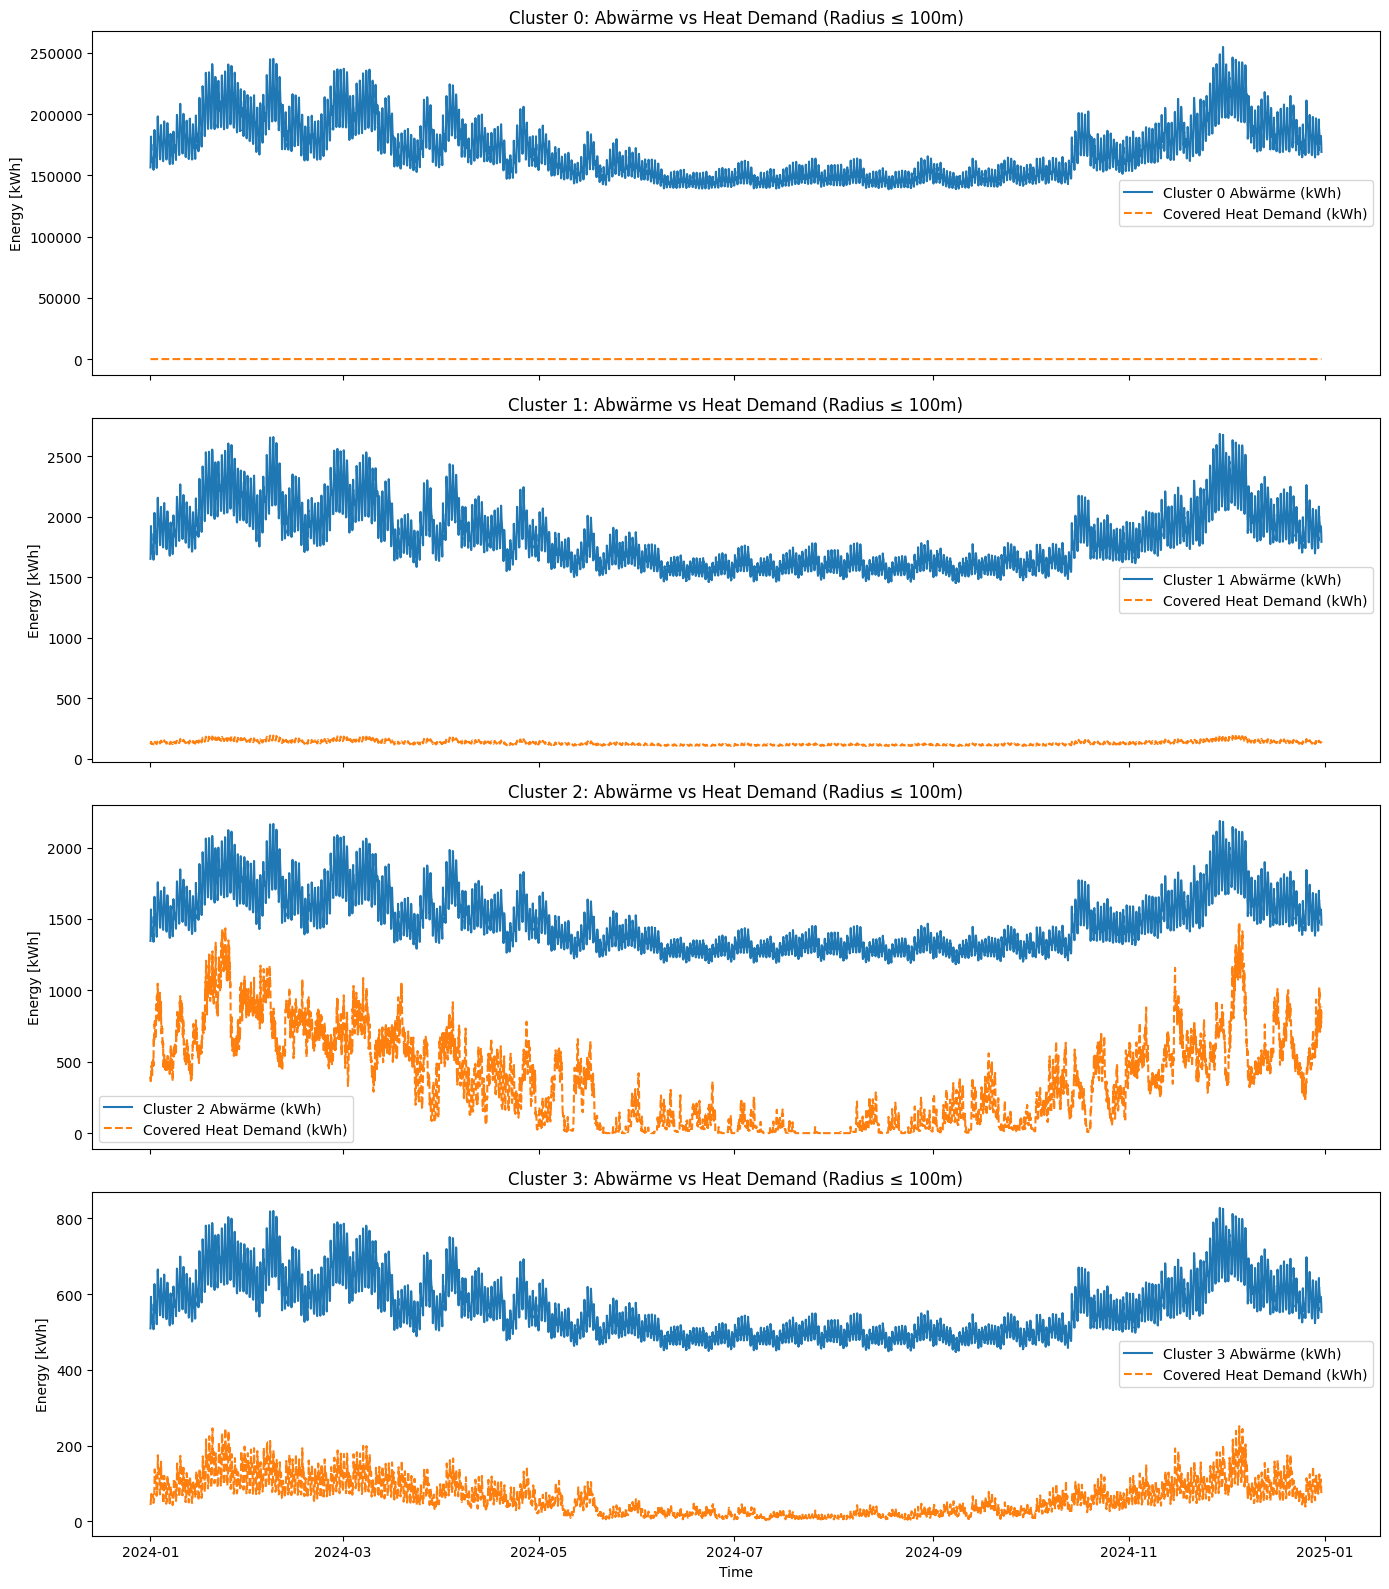

In [52]:
import matplotlib.pyplot as plt

# Set up plot grid
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 16), sharex=True)

# Iterate over clusters to plot Abwärme vs Demand
for cluster_id in range(4):
    cluster_name = f"Cluster {cluster_id}"
    abwaerme_profile = df_cluster_profiles[cluster_name]
    total_abwaerme_MWh = abwaerme_profile.sum() / 1000

    # Find buildings in cluster
    cluster_ids = gdf_top[gdf_top["cluster"] == cluster_id]["ID"].astype(str).tolist()
    cluster_buildings = gdf_gis[gdf_gis["ID"].astype(str).isin(cluster_ids)]
    cluster_centroid = cluster_buildings.geometry.union_all().centroid

    # Iteratively find demand that can be covered
    max_radius = 6000
    step = 100
    threshold = 0.70
    best_radius = None
    total_demand_profile = None

    for radius in range(step, max_radius + step, step):
        buffer = cluster_centroid.buffer(radius)

        nearby_buildings = gdf_gis[
            gdf_gis["geometry"].intersects(buffer) & ~gdf_gis["ID"].astype(str).isin(cluster_ids)
        ]
        nearby_ids = nearby_buildings["ID"].astype(int).tolist()
        nearby_ids = [i for i in nearby_ids if i in df_consumer_loads.columns]

        if not nearby_ids:
            continue

        df_nearby = df_consumer_loads[nearby_ids]
        building_demands = df_nearby.sum() / 1000  # MWh
        building_demands = building_demands.sort_values()

        covered_ids = []
        total = 0
        for b_id, demand in building_demands.items():
            if total + demand <= total_abwaerme_MWh:
                covered_ids.append(b_id)
                total += demand

        if not covered_ids:
            continue

        df_covered = df_consumer_loads[covered_ids]
        total_demand_profile = df_covered.sum(axis=1)
        total_nearby_demand_MWh = total_demand_profile.sum() / 1000
        coverage_ratio = total_abwaerme_MWh / total_nearby_demand_MWh

        best_radius = radius
        break

    # Plot
    ax = axes[cluster_id]
    ax.plot(abwaerme_profile.index, abwaerme_profile, label=f"{cluster_name} Abwärme (kWh)")
    if total_demand_profile is not None:
        ax.plot(total_demand_profile.index, total_demand_profile, linestyle='--', label="Covered Heat Demand (kWh)")
    ax.set_ylabel("Energy [kWh]")
    ax.set_title(f"{cluster_name}: Abwärme vs Heat Demand (Radius ≤ {best_radius}m)")
    ax.legend()

# Final formatting
axes[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()

# gdf_top.to_file(output_path / "clustered_abwaerme_buildings.geojson", driver="GeoJSON")



### Check only buildings that can use the heat waste wihtout depleting it

Processing Cluster 0
✅ Cluster 0: Coverage never dropped below 70%; using 6000m


/tmp/ipykernel_5008/510007819.py:115: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


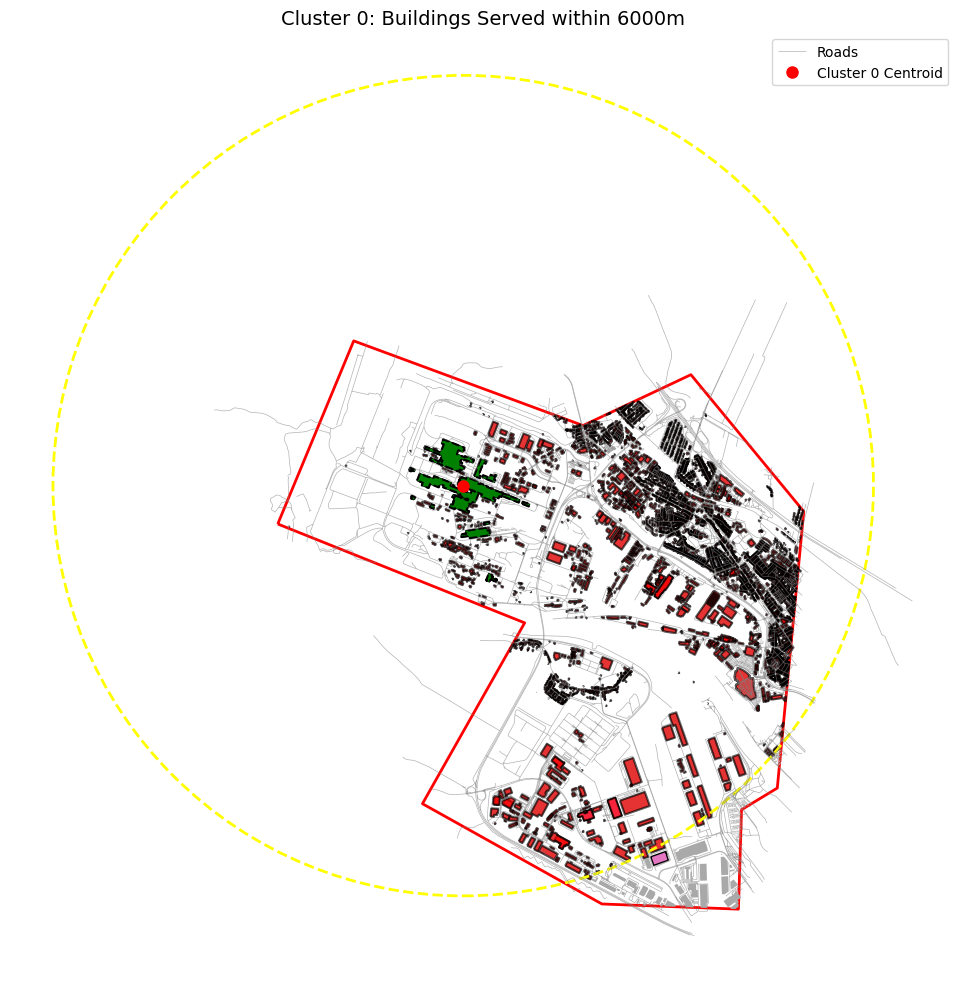

Processing Cluster 1
✅ Cluster 1: Coverage never dropped below 70%; using 6000m


/tmp/ipykernel_5008/510007819.py:115: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


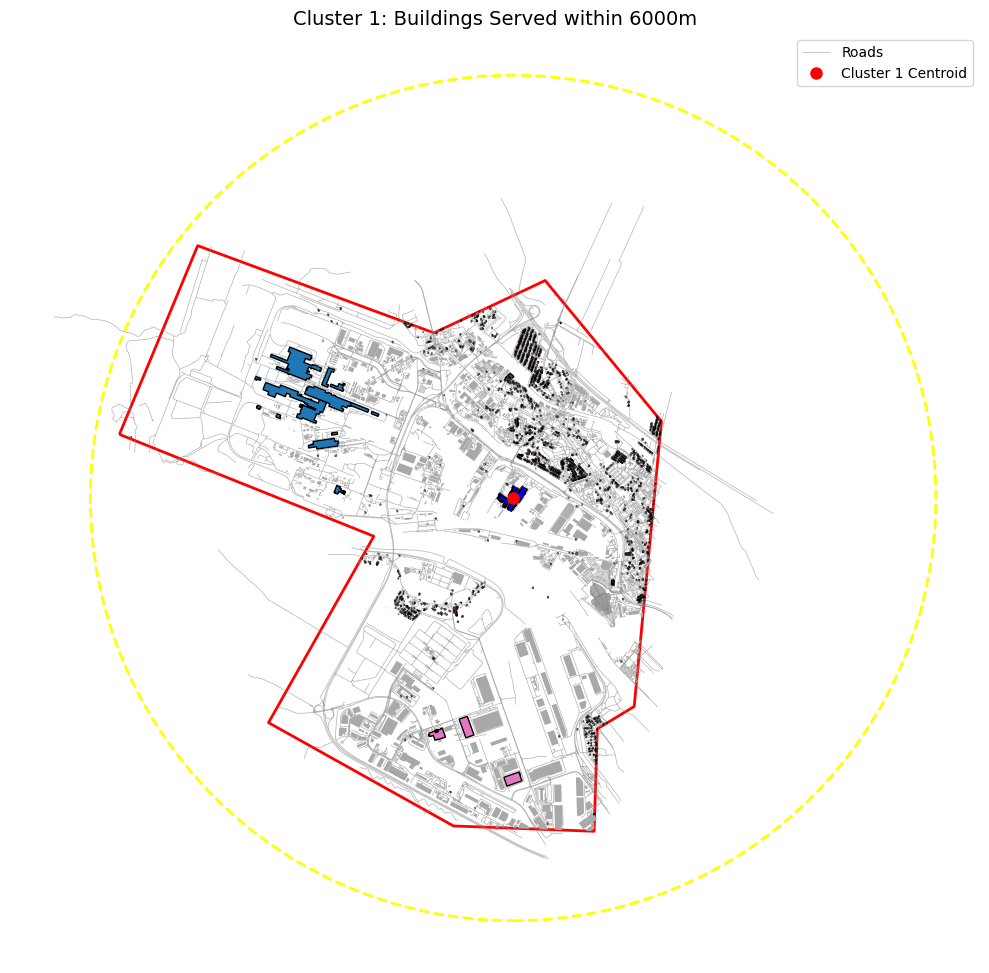

Processing Cluster 2
✅ Cluster 2: Coverage never dropped below 70%; using 6000m


/tmp/ipykernel_5008/510007819.py:115: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


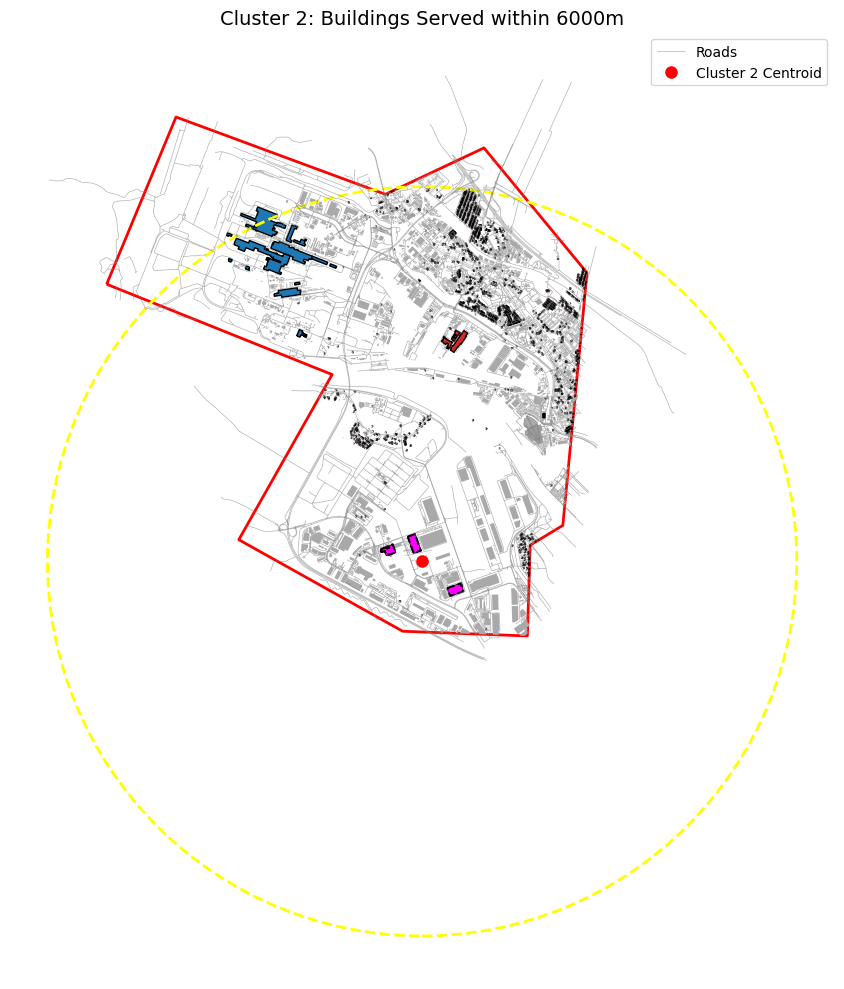

Processing Cluster 3


In [ ]:
 

# Cluster colors for up to 4 clusters
cluster_colors = {
    0: "green",
    1: "blue",
    2: "magenta",
    3: "pink"
}

summary_records = []

# Iterate over each cluster (0 to 3)
for cluster_id in range(4):
    cluster_name = f"Cluster {cluster_id}"
    print(f"Processing {cluster_name}")

    cluster_ids = gdf_top[gdf_top["cluster"] == cluster_id]["ID"].astype(str).tolist()
    cluster_buildings = gdf_gis[gdf_gis["ID"].astype(str).isin(cluster_ids)]
    cluster_centroid = cluster_buildings.geometry.union_all().centroid

    abwaerme_profile = df_cluster_profiles[cluster_name]
    total_abwaerme_MWh = abwaerme_profile.sum() / 1000  # kWh → MWh

    max_radius = 6000
    step = 100
    threshold = 0.70
    best_radius = None
    last_success_radius = None
    best_covered_ids = []
    final_nearby_buildings = None
    result_log = []

    for radius in range(step, max_radius + step, step):
        buffer = cluster_centroid.buffer(radius)

        nearby_buildings = gdf_gis[
            gdf_gis["geometry"].intersects(buffer) & ~gdf_gis["ID"].astype(str).isin(cluster_ids)
        ]
        nearby_ids = nearby_buildings["ID"].astype(int).tolist()
        nearby_ids = [i for i in nearby_ids if i in df_consumer_loads.columns]

        if not nearby_ids:
            continue

        # Calculate annual demand per building and sort ascending
        df_nearby = df_consumer_loads[nearby_ids]
        building_demands = df_nearby.sum() / 1000  # MWh
        building_demands = building_demands.sort_values()  # least demand first

        covered_ids = []
        total = 0
        for b_id, demand in building_demands.items():
            if total + demand <= total_abwaerme_MWh:
                covered_ids.append(b_id)
                total += demand
            else:
                continue  # allow skipping buildings with large demand

        if not covered_ids:
            continue

        df_covered = df_consumer_loads[covered_ids]
        total_demand_profile = df_covered.sum(axis=1)
        total_nearby_demand_MWh = total_demand_profile.sum() / 1000

        coverage_ratio = total_abwaerme_MWh / total_nearby_demand_MWh
        last_success_radius = radius
        final_nearby_buildings = gdf_gis[gdf_gis["ID"].astype(int).isin(covered_ids)]

        result_log.append({
            "cluster": cluster_name,
            "buffer_m": radius,
            "demand_MWh": total_nearby_demand_MWh,
            "coverage_%": min(coverage_ratio, 1.0) * 100,
            "surplus_MWh": max(total_abwaerme_MWh - total_nearby_demand_MWh, 0),
            "buildings_covered": len(covered_ids)
        })

        if coverage_ratio < threshold:
            best_radius = radius
            best_covered_ids = covered_ids
            break
        else:
            best_covered_ids = covered_ids

                # Store covered IDs per cluster
        if 'covered_by_cluster' not in globals():
            covered_by_cluster = {}

        covered_by_cluster[cluster_id] = best_covered_ids

    if best_radius is None:
        best_radius = last_success_radius
        print(f"✅ {cluster_name}: Coverage never dropped below {threshold:.0%}; using {best_radius}m")
    else:
        print(f"🟡 {cluster_name}: Coverage dropped below {threshold:.0%}; at {best_radius}m")

    summary_records.extend(result_log)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf_road.plot(ax=ax, color="gray", linewidth=0.5, alpha=0.6, label="Roads")
    gpd.GeoSeries([area_poly]).plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2, linestyle='-', label="Area Boundary")

    gdf_gis.plot(ax=ax, color="darkgray", linewidth=0.2)
    gdf_top.plot(ax=ax, column="cluster", cmap="tab10", legend=False, edgecolor="black")
    cluster_buildings.plot(ax=ax, facecolor=cluster_colors[cluster_id], edgecolor="black", linewidth=1.5, linestyle='--', label=f"{cluster_name} Buildings")
    final_nearby_buildings.plot(ax=ax, facecolor="red", edgecolor="black", linewidth=1.5, alpha=0.7, label="Covered Demand Buildings")

    ax.plot(cluster_centroid.x, cluster_centroid.y, 'ro', markersize=8, label=f"{cluster_name} Centroid")
    circle = plt.Circle((cluster_centroid.x, cluster_centroid.y), best_radius, color='yellow', fill=False, linestyle='--', linewidth=2)
    ax.add_patch(circle)

    ax.set_title(f"{cluster_name}: Buildings Served within {best_radius}m", fontsize=14)
    ax.axis("off")
    ax.legend()
    plt.tight_layout()
    plt.show()

# Final summary
tools.display_dataframe_to_user(name="Optimized Cluster Demand Coverage Summary", dataframe=pd.DataFrame(summary_records))


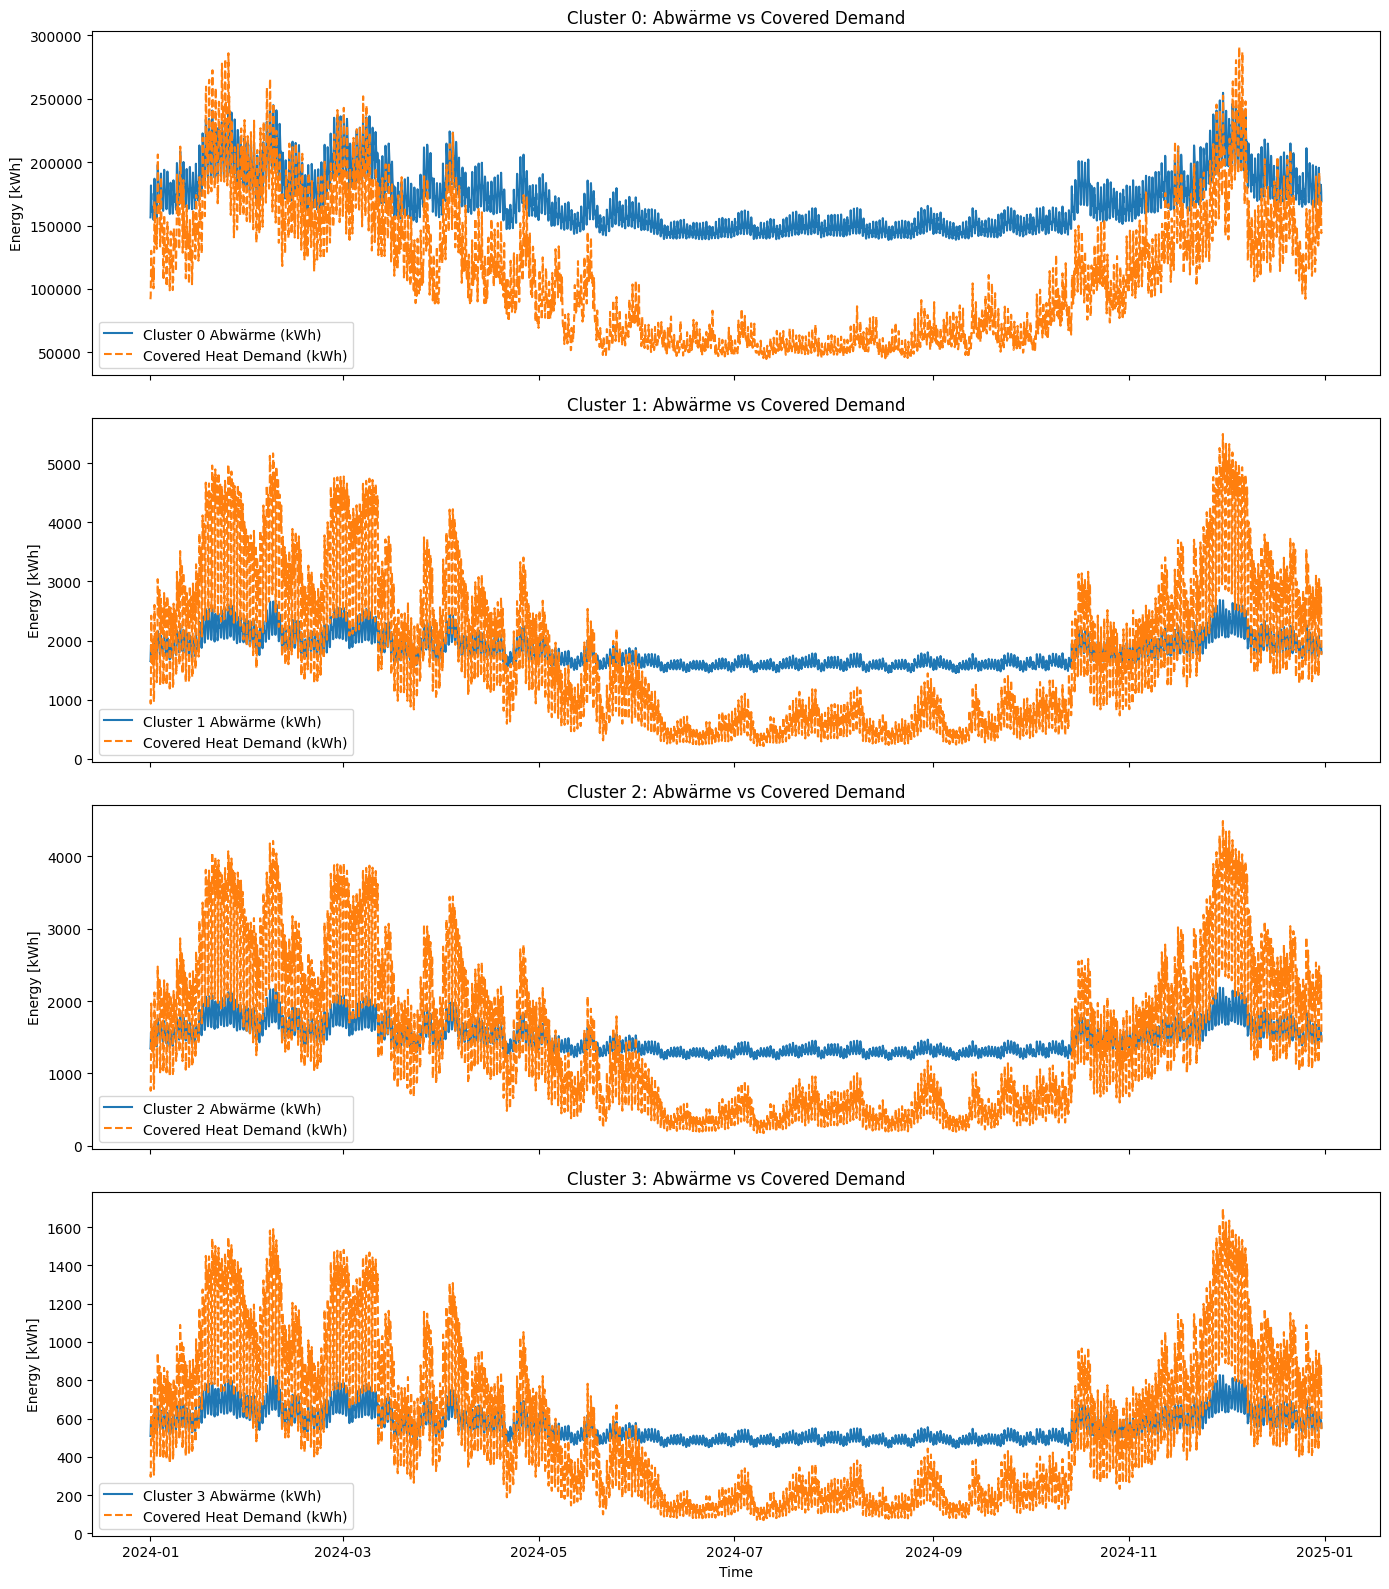

In [ ]:
import matplotlib.pyplot as plt

# Plot hourly comparison for all clusters
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 16), sharex=True)

for cluster_id in range(4):
    cluster_name = f"Cluster {cluster_id}"
    
    abwaerme_profile = df_cluster_profiles[cluster_name]
    total_abwaerme_MWh = abwaerme_profile.sum() / 1000

    # ✅ Use building IDs saved during the optimization loop
    covered_ids = covered_by_cluster.get(cluster_id, [])
    
    if not covered_ids:
        print(f"⚠️ No buildings covered for {cluster_name}")
        continue

    # Compute total heat demand profile for the covered buildings
    df_demand = df_consumer_loads[covered_ids].copy()
    total_demand_profile = df_demand.sum(axis=1)

    # Plot
    ax = axes[cluster_id]
    ax.plot(abwaerme_profile.index, abwaerme_profile, label=f"{cluster_name} Abwärme (kWh)")
    ax.plot(total_demand_profile.index, total_demand_profile, linestyle='-', label="Covered Heat Demand (kWh)")
    ax.set_ylabel("Energy [kWh]")
    ax.set_title(f"{cluster_name}: Abwärme vs Covered Demand")
    ax.legend()

axes[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()
